## Simulation for Diffuse foreground, 500 point sources and RFI. Then applying Inpainted data 

In this simulation, I add visibilities from 500 pntsrc, diffuse foreground and RFI output a UVdata object using hera_sim. Then I make a power spectrum plot using hera_pspec

In [1]:
from hera_sim.simulate import Simulator
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import uvtools
import copy

import hera_pspec as hp
from pyuvdata import UVData

from hera_sim.noise import HERA_Tsky_mdl
from hera_sim.data import DATA_PATH

/home/anks/.local/lib/python3.7/site-packages/hera_sim-0.1.0-py3.7.egg/hera_sim/visibilities/__init__.py:22: UserWarning: healvis failed to import.
  warnings.warn("healvis failed to import.")
/home/anks/.local/lib/python3.7/site-packages/hera_sim-0.1.0-py3.7.egg/hera_sim/__init__.py:35: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of interfacing with the hera_sim package features.
  FutureWarning)


### One baseline, 128 frequency channels, 50 times, 16 Hours

In [2]:
sim = Simulator(
    n_freq = 128,
    n_times = 50,
    antennas = {
        0: (20.0, 20.0, 0),
        1: (50.0, 50.0, 0)
    },
    no_autos=True,   # model only one baseline
    integration_time=3600*16./50, # roughly 24 hours of total time
)

In [3]:
sim.antpos

{0: array([ 2.00000000e+01,  2.00000000e+01, -4.53549731e-09]),
 1: array([ 5.00000000e+01,  5.00000000e+01, -4.40831371e-09])}

In [4]:
print(sim.data.get_antpairs())
print(sim.data.get_ants())
print(sim.data.Nbls)
print(sim.data.data_array.shape)

[(0, 1)]
[0 1]
1
(50, 1, 128, 1)


In [5]:
def waterfall(
    vis, freq=sim.data.freq_array[0]/1e6, lsts=sim.data.lst_array, 
    vmax=None, vrange=None, title=None,
):
    """
    A wrapper around the uvtools' waterfall function providing some
    extra labelling and plot adjustment. Specify data in the format 
    data_array[:,0,:,0]
    """
    fig, ax = plt.subplots(
        2,1, sharex=True, sharey=True, figsize=(12,10)
    )
    #vis[:,0,:,0]
    if title is not None:
        ax[0].set_title(title, fontsize=12)
    plt.sca(ax[0])
    uvtools.plot.waterfall(
        vis, mode='log', mx=vmax, drng=vrange,
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    plt.colorbar(label=r'log$_{10}$(Vis/Jy)')
    plt.ylabel("LST", fontsize=12)
    
    plt.sca(ax[1])
    uvtools.plot.waterfall(
        vis, 
        mode='phs',
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    plt.colorbar(label='Phase [rad]')
    plt.xlabel("Frequency [MHz]", fontsize=12)
    plt.ylabel("LST", fontsize=12)

#### Adding Adding Diffuse Foreground and 500 point sources

In [6]:
sim.add_foregrounds("diffuse_foreground",Tsky_mdl = HERA_Tsky_mdl['xx'])
sim.add_foregrounds("pntsrc_foreground", nsrcs = 500)

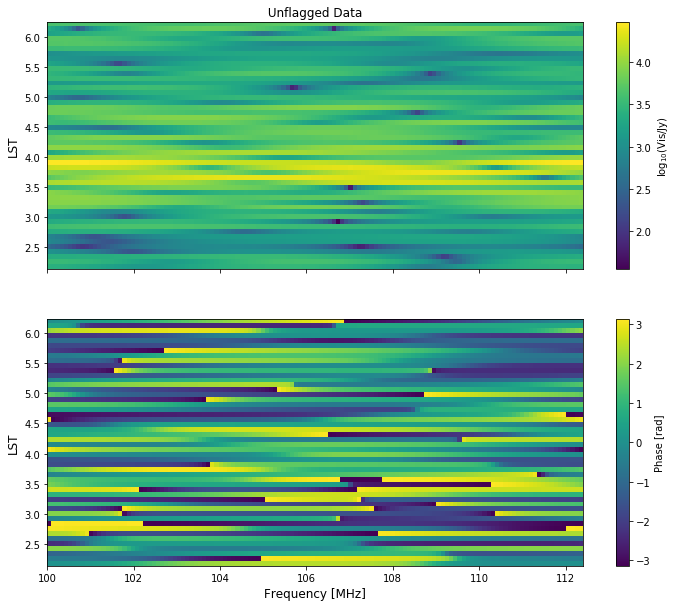

In [7]:
waterfall(sim.data.data_array[:,0,:,0], title=' Unflagged Data ')

### Plot Power Spectrum

In [8]:
# Load into UVData objects
uvd = copy.deepcopy(sim.data)


In [9]:
# Instantiate a Cosmo Conversions object
# we will need this cosmology to put the power spectra into cosmological units
cosmo = hp.conversions.Cosmo_Conversions()

# Load beam model
beamfile = '../data/HERA_NF_dipole_power.beamfits'

uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='XX')

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, None, :, None]

# We only have 1 data file here, so slide the time axis by one integration 
# to avoid noise bias (not normally needed!)
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

# here we phase all datasets in dsets to the zeroth dataset
ds.rephase_to_dset(0)
# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

# Specify which baselines to include
baselines = [(0,1)]

# we will use the baselines list to produce power spectra
# whose data will be drawn from the dsets[0] and dsets[1]
# across spectral window between channels 600 -- 700 with identity weighting and a blackman-harris taper
uvp = ds.pspec(baselines, baselines, (0, 1), [('xx', 'xx')], spw_ranges= None, 
               input_data_weight='identity', norm='I', taper='blackman-harris', verbose=True)


Setting spectral range: (0, 128)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((0, 1), (0, 1))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


In [10]:
# ds.pspec?

Text(0.5, 1.0, 'Unflagged data Power Spectrum')

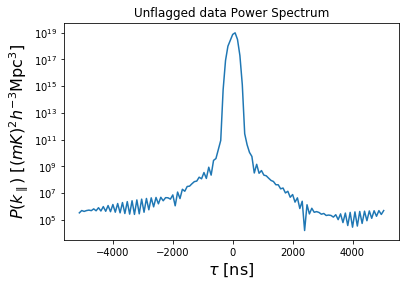

In [11]:
blpairs = np.unique(uvp.blpair_array)
# Unpack the list of baseline-pairs into a Python list
blps = [blp for blp in blpairs]

# Plot the spectra averaged over baseline-pairs and times
ax = hp.plot.delay_spectrum(uvp, [blps,], spw=0, pol=('xx','xx'), average_blpairs=False, average_times=True)
plt.title('Unflagged data Power Spectrum')

### Adding RFI
#### RFI Stations

In [12]:
np.argwhere(sim.data.flag_array[:,0,:,0] == True)

array([], shape=(0, 2), dtype=int64)

In [13]:
#Generate RFI
sim.data.data_array[:,0,10:11,0] = 1e9
sim.data.data_array[:,0,22:24,0] = 1e9
sim.data.data_array[:,0,36:37,0] = 1e9
sim.data.data_array[:,0,40:41,0] = 1e9 
sim.data.data_array[:,0,70:71,0] = 1e9
sim.data.data_array[:,0,88:89,0] = 1e9
sim.data.data_array[:,0,111:112,0] = 1e9

# Setting the flags
sim.data.flag_array[:,0,10:11,0] = np.invert(sim.data.flag_array[:,0,10:11,0])
sim.data.flag_array[:,0,22:24,0] = np.invert(sim.data.flag_array[:,0,22:24,0])
sim.data.flag_array[:,0,36:37,0] = np.invert(sim.data.flag_array[:,0,36:37,0])
sim.data.flag_array[:,0,40:41,0] = np.invert(sim.data.flag_array[:,0,40:41,0])
sim.data.flag_array[:,0,70:71,0] = np.invert(sim.data.flag_array[:,0,70:71,0])
sim.data.flag_array[:,0,88:89,0] = np.invert(sim.data.flag_array[:,0,88:89,0])
sim.data.flag_array[:,0,111:112,0] = np.invert(sim.data.flag_array[:,0,111:112,0])

# np.argwhere(sim.data.flag_array[:,0,:,0] == True)
# Load into UVData objects
uvd_flagged = copy.deepcopy(sim.data) # In Jy, not mK

uvd_inpainted = copy.deepcopy(uvd) ##Copied for later, already in mK

Casting complex values to real discards the imaginary part


(0, 30)

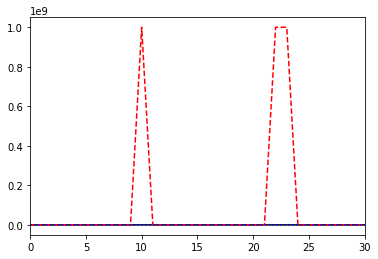

In [14]:
plt.plot(uvd.get_data(0,1)[20], 'k-')
plt.plot(uvd_flagged.get_data(0,1)[20], 'r--')
plt.plot(uvd_inpainted.get_data(0,1)[20], 'b:')
# plt.yscale('log')
plt.xlim((0, 30))

In [15]:
# np.argwhere(sim.data.flag_array[:,0,:,0] == True)
# Flagged = True means that freq. channel is flagged and has RFI

In [16]:
# sim.add_rfi("rfi_stations",)
# sim.add_rfi("rfi_impulse", chance=0.1, strength=100.0)
# sim.add_rfi("rfi_scatter", chance=0.1, strength=20, std = 5)
# NOTE: hera_sim add_rfi method doesn't seem to add flags to the sim.data.flag_array ??

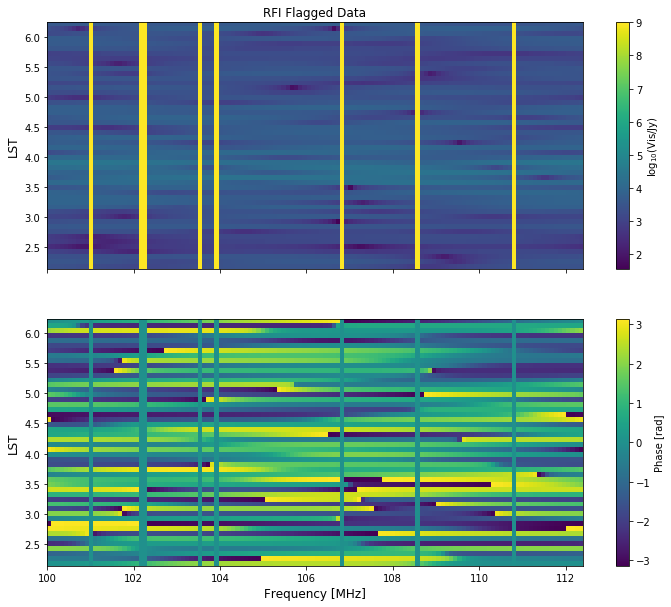

In [17]:
waterfall(uvd_flagged.data_array[:,0,:,0], title='RFI Flagged Data')

In [18]:
# Instantiate a Cosmo Conversions object
# we will need this cosmology to put the power spectra into cosmological units
cosmo = hp.conversions.Cosmo_Conversions()

# Load beam model
beamfile = '../data/HERA_NF_dipole_power.beamfits'

uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd_flagged.freq_array), pol='XX')

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd_flagged.data_array *= Jy_to_mK[None, None, :, None]

# We only have 1 data file here, so slide the time axis by one integration 
# to avoid noise bias (not normally needed!)
uvd1_flagged = uvd_flagged.select(times=np.unique(uvd_flagged.time_array)[:-1:2], inplace=False)
uvd2_flagged = uvd_flagged.select(times=np.unique(uvd_flagged.time_array)[1::2], inplace=False)

# Create a new PSpecData object
ds_flagged = hp.PSpecData(dsets=[uvd1_flagged, uvd2_flagged], wgts=[None, None], beam=uvb)
# here we phase all datasets in dsets to the zeroth dataset
ds_flagged.rephase_to_dset(0)
# change units of UVData objects
ds_flagged.dsets[0].vis_units = 'mK'
ds_flagged.dsets[1].vis_units = 'mK'

# Specify which baselines to include
baselines_flagged = [(0,1)]

uvp_flagged = ds.pspec(baselines_flagged, baselines_flagged, (0, 1), [('xx', 'xx')], spw_ranges= None, 
               input_data_weight='identity', norm='I', taper='blackman-harris', verbose=True)




Setting spectral range: (0, 128)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((0, 1), (0, 1))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


Text(0.5, 1.0, 'Flagged data Power Spectrum')

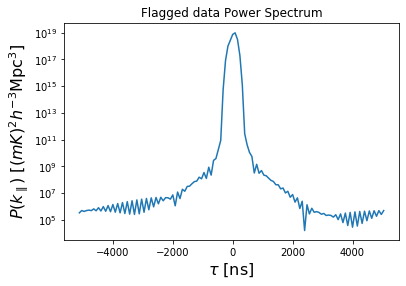

In [19]:
blpairs_flagged = np.unique(uvp_flagged.blpair_array)
# Unpack the list of baseline-pairs into a Python list
blps_flagged = [blp for blp in blpairs_flagged]

# Plot the spectra averaged over baseline-pairs and times
ax_flagged = hp.plot.delay_spectrum(uvp_flagged, [blps_flagged,], spw=0, pol=('xx','xx'), 
                                    average_blpairs=False, average_times=True)
plt.title('Flagged data Power Spectrum')

### In-Painting data

In [20]:
# Creating a copy of UVData object for later use
# uvd_inpainted = copy.deepcopy(uvd_flagged)

#2D Data and flags
data = uvd_flagged.data_array[:,0,:,0]
flags = uvd_flagged.flag_array[:,0,:,0]
sigma = 0.01
nmax = 50

#Apllying Delay filter
model, model_coeff, data_out = uvtools.dspec.delay_filter_leastsq(data, flags, sigma, nmax)

# Replacing original data with in-painted data
uvd_inpainted.data_array[:,0,:,0] = data_out 

In [21]:
help(uvtools.dspec.delay_filter_leastsq)

Help on function delay_filter_leastsq in module uvtools.dspec:

delay_filter_leastsq(data, flags, sigma, nmax, add_noise=False, cn_guess=None, use_linear=True, operator=None)
    Fit a smooth model to each 1D slice of 2D complex-valued data with flags,
    using a linear least-squares solver. The model is a Fourier series up to a
    specified order. As well as calculating a best-fit model, this will also
    return a copy of the data with flagged regions filled in ('in-painted')
    with the smooth solution.
    
    Optionally, you can also add an uncorrelated noise realization on top of
    the smooth model in the flagged region.
    
    N.B. This is just a wrapper around delay_filter_leastsq_1d() but with some
    time-saving precomputations. It fits to each 1D slice of the data
    individually, and does not perform a global fit to the 2D data.
    
    Parameters
    ----------
    data : array_like, complex
        Complex visibility array as a function of frequency, with shape

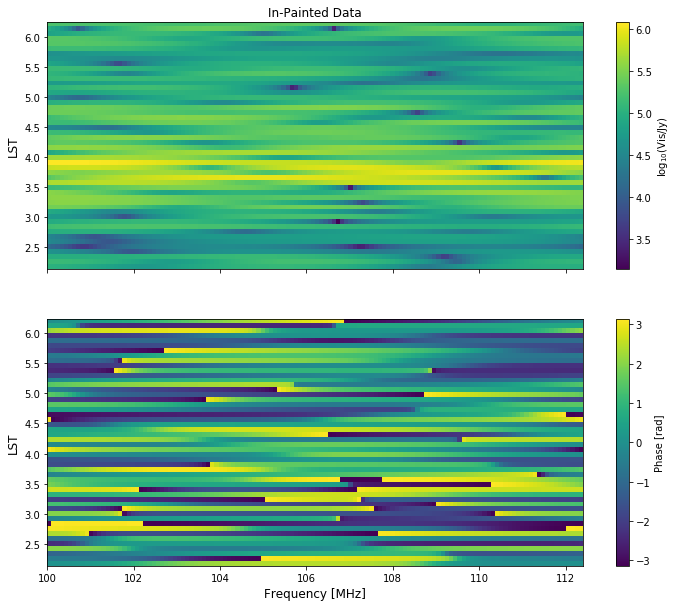

In [22]:
waterfall(uvd_inpainted.data_array[:,0,:,0], title='In-Painted Data')

In [23]:
# Re-Setting the flags, making flags false

# uvd_inpainted.flag_array[:,0,10:11,0] = np.invert(uvd_inpainted.flag_array[:,0,10:11,0])
# uvd_inpainted.flag_array[:,0,22:24,0] = np.invert(uvd_inpainted.flag_array[:,0,22:24,0])
# uvd_inpainted.flag_array[:,0,36:37,0] = np.invert(uvd_inpainted.flag_array[:,0,36:37,0])
# uvd_inpainted.flag_array[:,0,40:41,0] = np.invert(uvd_inpainted.flag_array[:,0,40:41,0])
# uvd_inpainted.flag_array[:,0,70:71,0] = np.invert(uvd_inpainted.flag_array[:,0,70:71,0])
# uvd_inpainted.flag_array[:,0,88:89,0] = np.invert(uvd_inpainted.flag_array[:,0,88:89,0])
# uvd_inpainted.flag_array[:,0,111:112,0] = np.invert(uvd_inpainted.flag_array[:,0,111:112,0])

# np.argwhere(uvd_inpainted.flag_array[:,0,:,0] == True)

In [24]:
cosmo = hp.conversions.Cosmo_Conversions()
# Load beam model
beamfile = '../data/HERA_NF_dipole_power.beamfits'

uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# find conversion factor from Jy to mK
#Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd_inpainted.freq_array), pol='XX')


# reshape to appropriately match a UVData.data_array object and multiply in!
#uvd_inpainted.data_array *= Jy_to_mK[None, None, :, None]


# We only have 1 data file here, so slide the time axis by one integration 
# to avoid noise bias (not normally needed!)
uvd1_inpainted = uvd_inpainted.select(times=np.unique(uvd_inpainted.time_array)[:-1:2], inplace=False)
uvd2_inpainted = uvd_inpainted.select(times=np.unique(uvd_inpainted.time_array)[1::2], inplace=False)


# Create a new PSpecData object
ds_inpainted = hp.PSpecData(dsets=[uvd1_inpainted, uvd2_inpainted], wgts=[None, None], beam=uvb)
ds_inpainted.rephase_to_dset(0) # Phase to the zeroth dataset


# change units of UVData objects
ds_inpainted.dsets[0].vis_units = 'mK'
ds_inpainted.dsets[1].vis_units = 'mK'


# Specify which baselines to include
baselines_inpainted = [(0,1)]


uvp_inpainted = ds_inpainted.pspec(baselines_inpainted, baselines_inpainted, (0, 1), [('xx', 'xx')], spw_ranges= None, 
               input_data_weight='identity', norm='I', taper='blackman-harris', verbose=True)



Setting spectral range: (0, 128)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((0, 1), (0, 1))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


Text(0.5, 1.0, 'In-Painted data Power Spectrum')

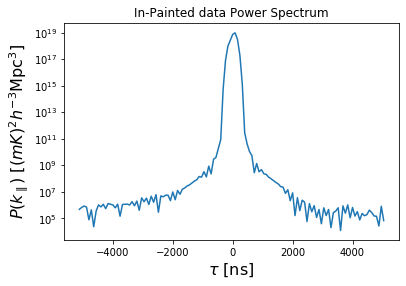

In [25]:
blpairs_inpainted = np.unique(uvp_inpainted.blpair_array)
# Unpack the list of baseline-pairs into a Python list
blps_inpainted = [blp_new for blp_new in blpairs_inpainted]

# Plot the spectra averaged over baseline-pairs and times
ax_inpainted = hp.plot.delay_spectrum(uvp_inpainted, [blps_inpainted,], spw=0, pol=('xx','xx'), 
                            average_blpairs=False, average_times=True)
plt.title('In-Painted data Power Spectrum')

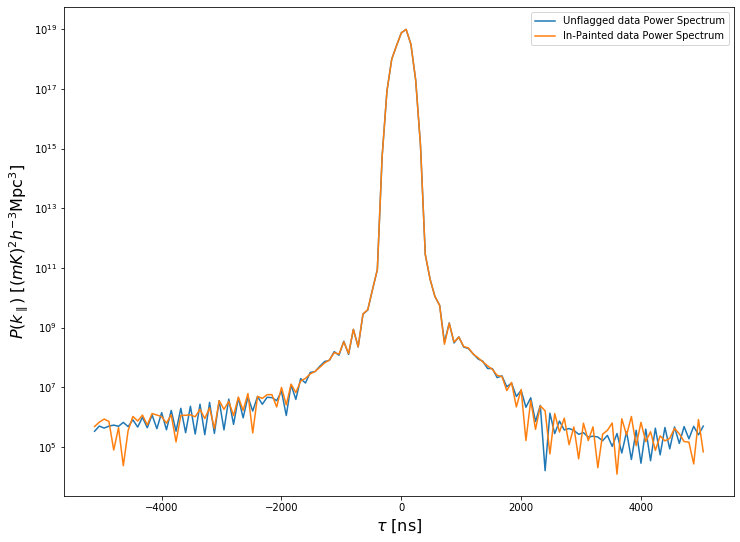

In [26]:
fig1 = plt.figure(figsize=(12,9))
ax1 = fig1.add_subplot(111)
ax = hp.plot.delay_spectrum(uvp, [blps,], spw=0, pol=('xx','xx'), 
                            average_blpairs=False, average_times=True, ax = ax1)

ax_inpainted = hp.plot.delay_spectrum(uvp_inpainted, [blps_inpainted,], spw=0, pol=('xx','xx'), 
                            average_blpairs=False, average_times=True, ax=plt.gca())
ax1.legend(['Unflagged data Power Spectrum','In-Painted data Power Spectrum'], loc = 'upper right')
